# Extract Device Benchmarks

Extract benchmarks like Layer Fidelity (LF), Error per Layered Gate (EPLG), and 2Q errors. This notebook can be easily adjusted to extract any other type of device information.

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import re
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_device_benchmarking.utilities.gate_map import plot_gate_map
from qiskit_device_benchmarking.utilities.layer_fidelity_utils import get_lf_chain
from scipy import stats
from datetime import datetime, timedelta
from typing import List, Dict

# Get backends

In [2]:
# load service
service = QiskitRuntimeService()

In [3]:
# Specify a lits of backends
backend_names = ['ibm_torino', 'ibm_sherbrooke', 'ibm_fez']

#add a flag to report average error per layered gate (as reported in iqp) or process error per layered gate
average_error = True
if average_error:
    eplg_prefact = 4/5.
else:
    eplg_prefact = 1.

In [4]:
# Get inidividual backends
backends = {}
for machine in backend_names:
    backend = service.backend(machine, instance='')
    backends[machine] = backend  

# Extract backend LF information

In [5]:
# Get Layer Fidelity (lf) data from backend properties
qchains = {}
lengths = {}
lfs = {}
eplgs = {}
for machine in backend_names:
    backend = backends[machine]
    # retrieve the best 100Q chain
    qchains[machine] = get_lf_chain(backend, 100)
    # retrieve lf array
    length = []
    lf = []
    for prop in backend.properties().general:
        prop_dict = prop.to_dict()
        if 'lf' in prop_dict ['name']:
            l = int(re.findall(r'\d+', prop_dict ['name'])[0])
            length.append(l)
            lf.append(prop_dict ['value'])
    lfs[machine] = lf
    lengths[machine] = length
    num_2q_gates = [l - 1 for l in length]
    # calculate eplg array from lf
    eplg = [eplg_prefact*(1 - (fid ** (1 / num_2q))) for num_2q, fid in zip(num_2q_gates, lf)]
    eplgs[machine] = eplg  

# Plot LF and EPLG data

In [6]:
# Define plot colors and markers
markers = ['o','s','v', 'p', '*', 'd', 'x']
colors =  ['blue', 'deeppink', 'green', 'red', 'gold', 'brown', 
          'steelblue', 'gray', 'lightgreen', 'darkmagenta', 'orange', 'lightskyblue', 'royalblue']

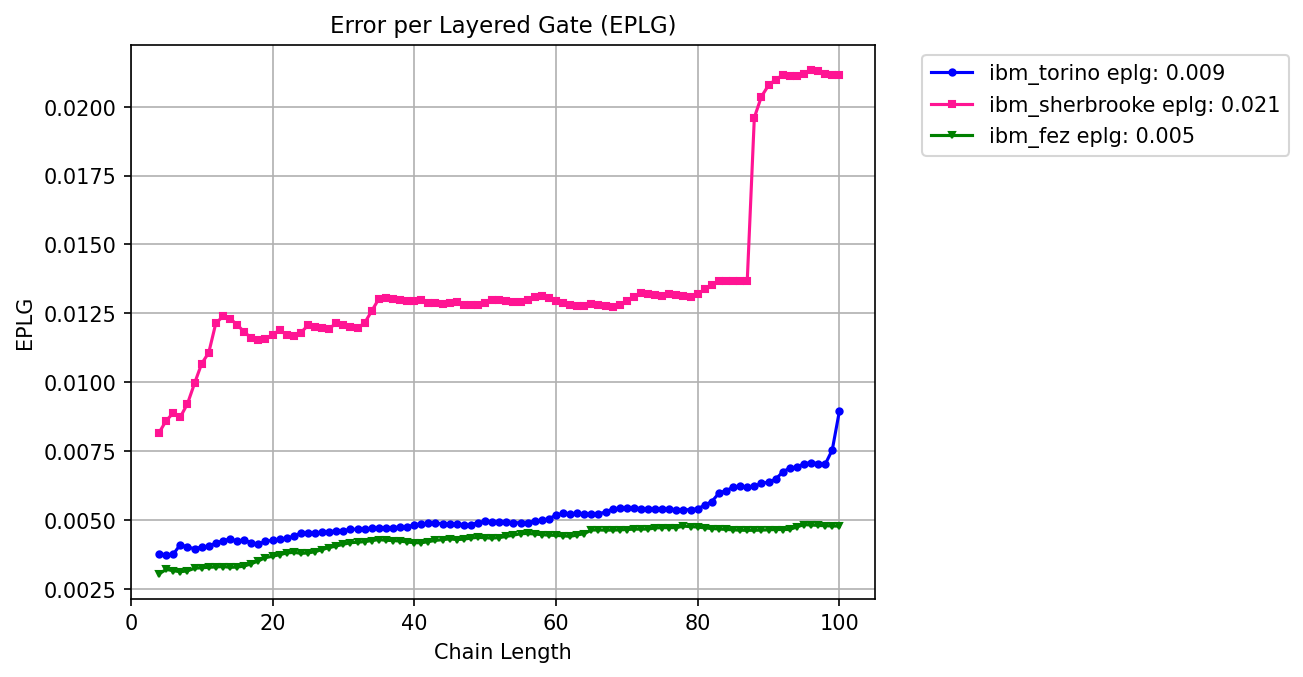

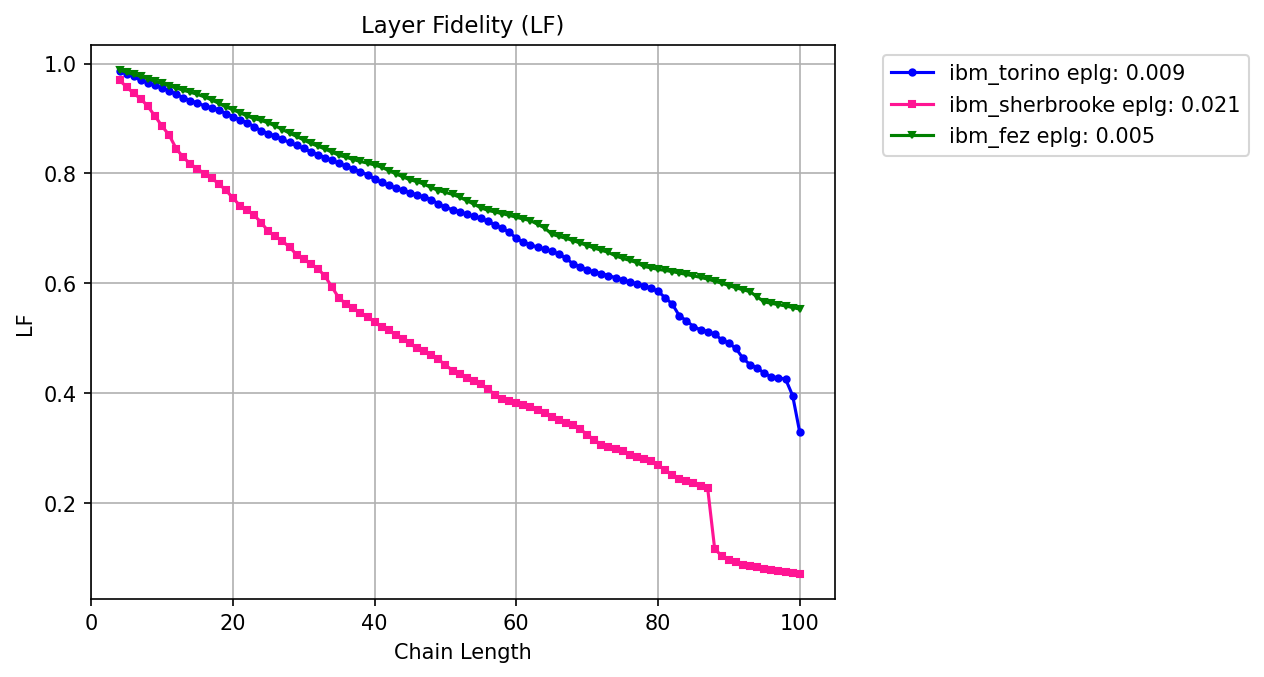

In [7]:
# Plot lf and eplg data per device
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
for i, machine in enumerate(backend_names):
    ax1.plot(lengths[machine], eplgs[machine], marker=markers[i % len(markers)], color=colors[i % len(colors)], markersize=3, linestyle="-", label= f'{machine} eplg: {round(eplgs[machine][-1],3)}')
    ax2.plot(lengths[machine], lfs[machine], marker=markers[i % len(markers)], color=colors[i % len(colors)], markersize=3, linestyle="-", label= f'{machine} eplg: {round(eplgs[machine][-1],3)}')

ax1.set_title(f"Error per Layered Gate (EPLG)", fontsize=11)
ax1.set_xlim(0, lengths[machine][-1] * 1.05)
ax1.set_ylabel("EPLG")
ax1.set_xlabel("Chain Length")
ax1.grid()
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.figure.set_dpi(150)
# fig1.savefig('eplg.png', dpi=150, bbox_inches='tight')

ax2.set_title(f"Layer Fidelity (LF)", fontsize=11)
ax2.set_xlim(0, lengths[machine][-1] * 1.05)
ax2.set_ylabel("LF")
ax2.set_xlabel("Chain Length")
ax2.grid()
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.figure.set_dpi(150)
# fig2.savefig('lf.png', dpi=150, bbox_inches='tight')

# Print and plot the best 100Q chain for each backend

In [10]:
# Print the best 100Q chain per backend
for machine in backend_names:
    print(f'Best 100Q chain for {machine}:')
    print(qchains[machine])

Best 100Q chain for ibm_torino:
[20, 19, 15, 0, 1, 2, 3, 4, 16, 23, 24, 25, 35, 44, 45, 46, 47, 48, 36, 29, 28, 27, 17, 8, 9, 10, 11, 12, 18, 31, 32, 33, 37, 52, 51, 50, 56, 69, 70, 71, 75, 90, 89, 88, 87, 86, 74, 67, 66, 65, 64, 63, 62, 61, 54, 42, 41, 40, 39, 38, 53, 57, 58, 59, 72, 78, 77, 76, 91, 95, 96, 97, 110, 116, 117, 118, 119, 120, 111, 101, 100, 99, 92, 80, 81, 82, 83, 84, 93, 103, 104, 105, 112, 124, 125, 126, 127, 128, 113, 109]
Best 100Q chain for ibm_sherbrooke:
[59, 58, 71, 77, 76, 75, 90, 94, 95, 96, 109, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 112, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 91, 79, 80, 81, 72, 62, 61, 60, 53, 41, 40, 39, 33, 20, 19, 18, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 30, 31, 32, 36, 51, 50, 49, 48, 47, 35, 28, 27, 26, 25, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73, 85, 86, 87, 88, 89, 74, 70, 69, 68]
Best 100Q chain for ibm_fez:
[81, 76, 61, 62, 63, 56, 43, 42, 41, 36, 21, 22, 23, 16, 3, 4, 5, 6, 7, 17

100Q chain for ibm_fez


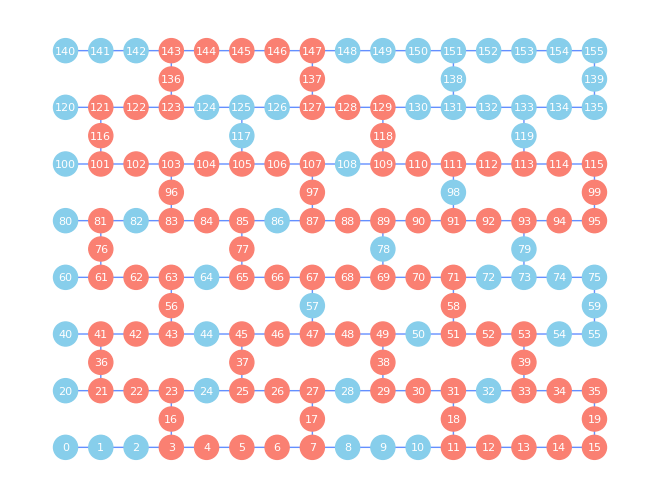

In [12]:
# Plot the best 100Q chain for a machine
machine = 'ibm_fez'
print(f'100Q chain for {machine}')
qcolors = ['salmon' if i in qchains[machine] else 'skyblue' for i in range(0, backends[machine].configuration().n_qubits)]
plot_gate_map(backends[machine], label_qubits=True, qubit_color=qcolors)

# Extract and plot 2Q error distribution for each backend

In [8]:
# Get 2q errors for each backend
tqerrors = {}
for machine in backend_names:
    # Get 2q gate
    backend = backends[machine]
    if "ecr" in backend.configuration().basis_gates:
        twoq_gate = "ecr"
    elif "cz" in backend.configuration().basis_gates:
        twoq_gate = "cz"
    else:
        twoq_gate = 'cx'

    # Extract 2q gate errors
    errors = []
    reset = []
    for gate in backend.properties().gates:
        gate_dict = gate.to_dict()
        if twoq_gate in gate_dict['gate']:
            error = gate_dict['parameters'][0]['value']
            errors.append(error)
    tqerrors[machine] = errors

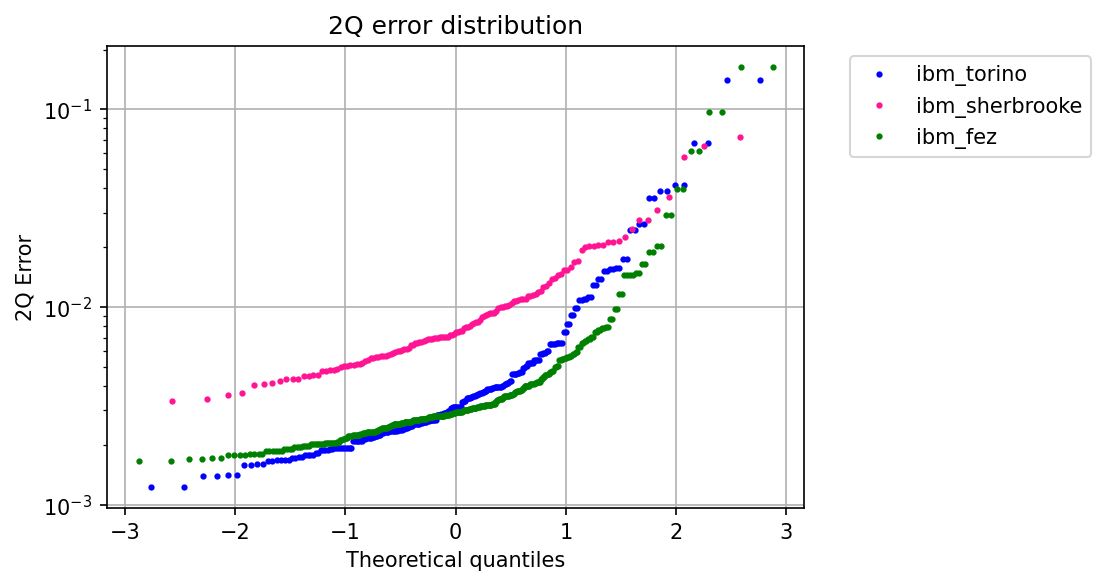

In [147]:
# Plot the distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
legend = []
for i, machine in enumerate(backend_names):
    errors = [x for x in tqerrors[machine] if 0<x<1] # clip values outside of normal range
    stats.probplot(errors, plot=plt, fit=False)
    ax.get_lines()[i].set_color(colors[i%len(colors)])
    plt.setp(ax.get_lines()[i], markersize=2)  #
    legend.append(machine)
ax.legend(legend, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('2Q error distribution')
ax.set_ylabel('2Q Error')
ax.figure.set_dpi(150)
plt.yscale('log')
plt.grid()
plt.show()

# Extract and plot 1Q distributions for each backend

In [10]:
# Specify list of properties for each backend
prop_list = ['T1','T2','1Q Error','Readout Error']
prop_unit = ['us','us','','']
prop_scale = [1e-6,1e-6,1,1]

In [207]:
def get_1q_distributions(backends: Dict, backend_names: List[str], prop_ind: int=0, date: datetime=None, qubits: List=None) -> Dict:
    """
    Get 1Q distribution of backends from a specified index prop_ind
    
    Args:
        backends (Dict): dictionary containing all backends, keys are backend names
        backend_names (List[str]): list containing properties info
        prop_ind (int): index representing which property to plot
        date (datetime): date to retrieve data from
        qubits (List): list of qubits to retrieve information from, if None, this defaults to all qubits on a device

    Returns:
        oneqprops (Dict): dictionary of 1Q distribution for all backends, keys are backend names
    """
    oneqprops = {}
    for machine in backend_names:
        backend = backends[machine]
        if qubits is None:
            nq = range(backend.configuration().n_qubits) # number of qubits
        else:
            nq = qubits

        # Extract 1Q properties
        props = []
        for qnum in nq:
            if prop_ind==0:
                if date is None:
                    props.append(backend.properties().t1(qnum))
                else:
                    props.append(backend.properties(datetime=date).t1(qnum))
            elif prop_ind==1:
                if date is None:
                    props.append(backend.properties().t2(qnum))
                else:
                    props.append(backend.properties(datetime=date).t2(qnum))
            elif prop_ind==2:
                if date is None:
                    props.append(backend.properties().gate_error('sx',qnum))
                else:
                    props.append(backend.properties(datetime=date).gate_error('sx',qnum))
            elif prop_ind==3:
                if date is None:
                    props.append(backend.properties().readout_error(qnum))
                else:
                    props.append(backend.properties(datetime=date).readout_error(qnum))
            else:
                raise ValueError('Not a valid property selection, prop_ind must be < %d'%len(prop_list))
        oneqprops[machine] = props
    return oneqprops

def plot_1q_distribution(oneqprops: Dict, prop_list: List[str], prop_unit: List[str], prop_ind: int=0) -> None:
    """
    Plot 1Q distribution of backends
    
    Args:
        oneqprops (Dict): dicitonary containing data of all backends, keys are backend names
        prop_list (List): list containing properties info
        prop_unit (List): list containing unit info
        prop_ind (int): index representing which property to plot
    """
    # Plot the distribution
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    legend = []
    for i, (machine, data) in enumerate(oneqprops.items()):
        #errors = [x for x in data if 0<x<1] # clip values outside of normal range
        stats.probplot(np.array(data)/prop_scale[prop_ind], plot=plt, fit=False)
        ax.get_lines()[i].set_color(colors[i%len(colors)])
        plt.setp(ax.get_lines()[i], markersize=2)  #
        legend.append(machine)
    ax.legend(legend, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title('%s distribution'%prop_list[prop_ind])
    if len(prop_unit[prop_ind])>0:
        ax.set_ylabel('%s (%s)'%(prop_list[prop_ind],prop_unit[prop_ind]))
    else:
        ax.set_ylabel('%s'%(prop_list[prop_ind]))
    ax.figure.set_dpi(150)
    ax.set_yscale('log')
    plt.grid()
    plt.show()

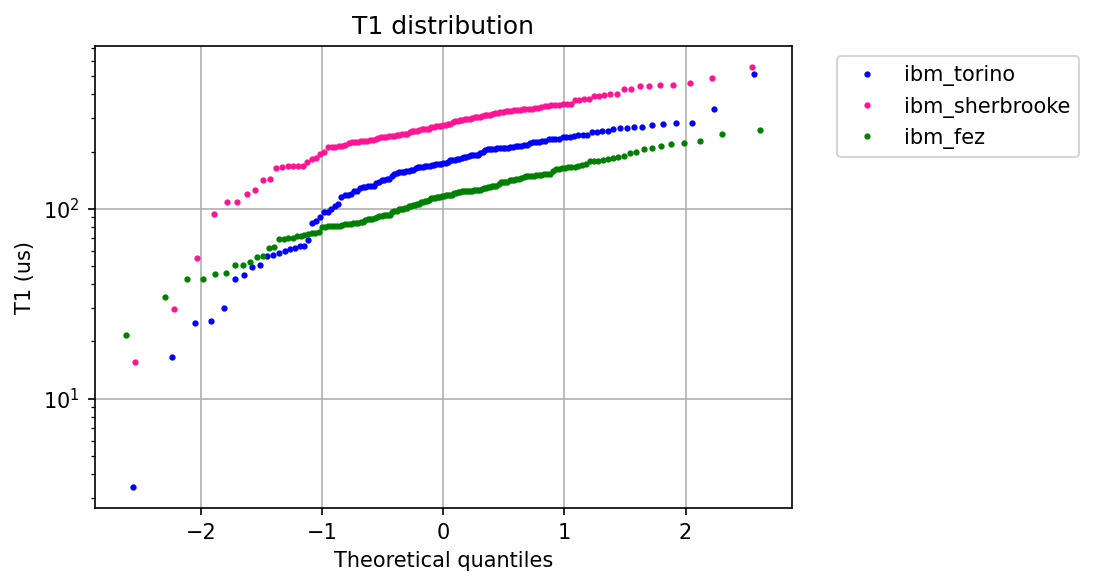

In [208]:
# Plot T1 distribution
oneqprops = get_1q_distributions(backends, backend_names, prop_ind=0)
plot_1q_distribution(oneqprops, prop_list, prop_unit, prop_ind=0)

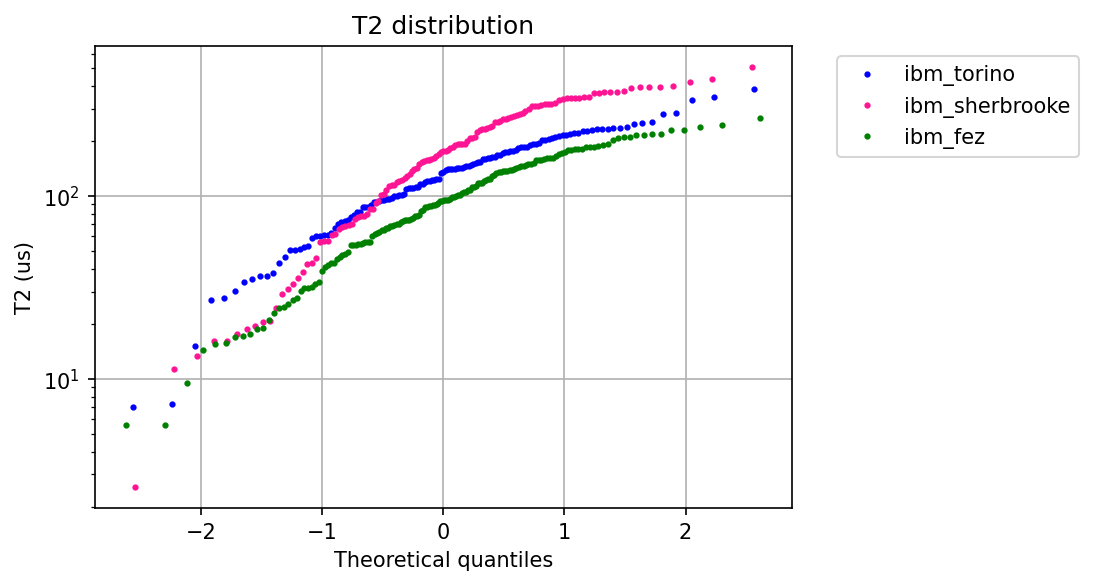

In [166]:
# Plot T2 distribution
oneqprops = get_1q_distributions(backends, backend_names, prop_ind=1)
plot_1q_distribution(oneqprops, prop_list, prop_unit, prop_ind=1)

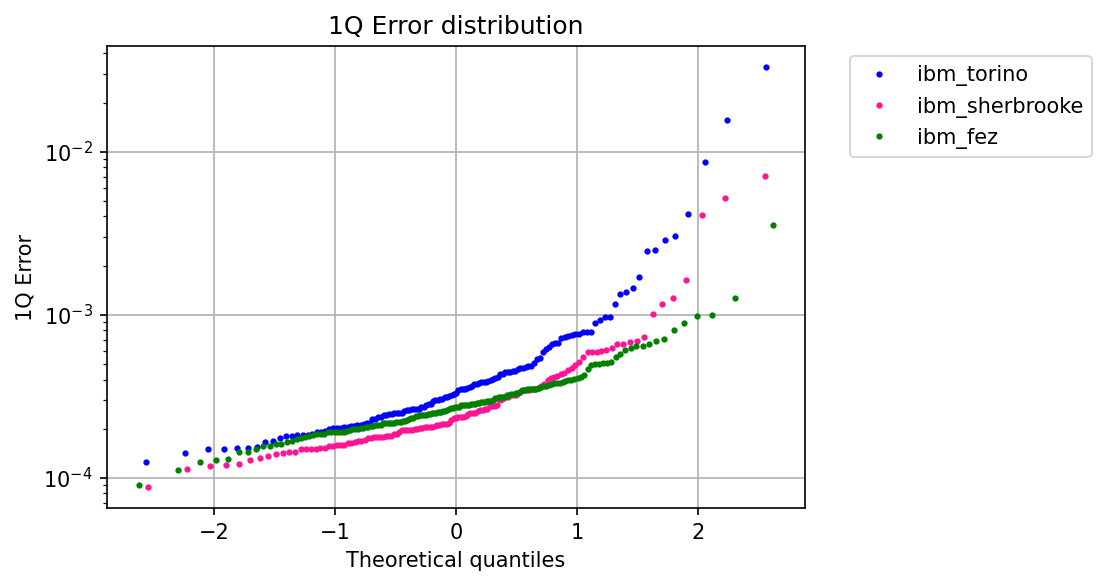

In [167]:
# Plot 1Q distribution
oneqprops = get_1q_distributions(backends, backend_names, prop_ind=2)
plot_1q_distribution(oneqprops, prop_list, prop_unit, prop_ind=2)

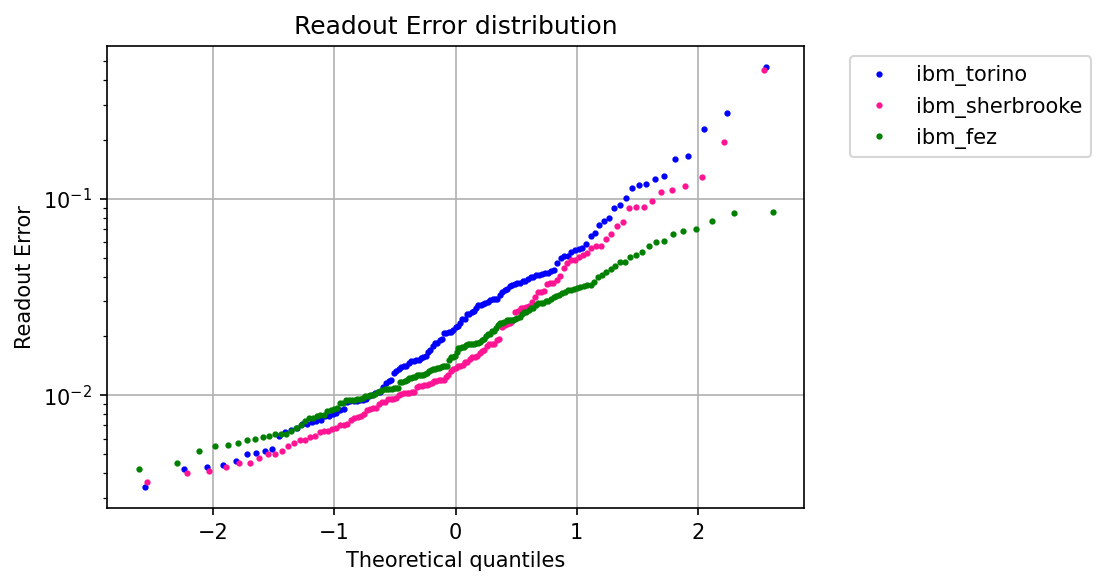

In [168]:
# Plot Readout distribution
oneqprops = get_1q_distributions(backends, backend_names, prop_ind=3)
plot_1q_distribution(oneqprops, prop_list, prop_unit, prop_ind=3)

# Extract historical data for each backend

In [96]:
def generate_datetime_range(start: datetime, end: datetime, step_days: int) -> List[datetime]:
    """
    Generate a list of datetime objects between start and end with a specified step.
    
    Args:
        start (datetime): The starting datetime
        end (datetime): The ending datetime
        step_days (int): Number of days between each datetime in the list
    
    Returns:
        List[datetime]: List of datetime objects
    """
    times = []
    current = start
    
    while current <= end:
        times.append(current)
        current += timedelta(days=step_days)
    
    return times

In [185]:
# Extract historical data
def extract_historical_data(backends: Dict, backend_names: List[str], start: datetime, end: datetime, step_days: int=1, prop_ind: int=0, quantiles: list=[0.1,0.25,0.5,0.75,0.9], qubits: List=None) -> tuple[Dict,Dict,Dict,Dict]: 
    """
    Extract historical data between start and end with a specified step.
    
    Args:
        backends (Dict): dictionary containing backends
        backend_names (List[str]): list of backend names
        start (datetime): The starting datetime
        end (datetime): The ending datetime
        step_days (int): Number of days between each datetime in the list
        prop_ind (int): Property index to extract, see list prop_list
        quantiles (list): list of quantiles to extract
    
    Returns:
        data_mean (List[float]): list of mean historical data
        data_median (List[float]): list of median historical data
        data_std (List[float]): list of std historical data
        data_quantiles (List[np.ndarray]): list of arrays containing quantiles historical data
    """
    dates = generate_datetime_range(start, end, step_days=1) # list of datetimes between the start and end dates
    data_mean = {}
    data_median = {}
    data_std = {}
    data_quantiles = {}
    # loop through backends
    for machine in backend_names:
        data_mean[machine] = []
        data_median[machine] = []
        data_std[machine] = []
        data_quantiles[machine] = []
        # loop through time
        for date in dates:
            oneqprops = get_1q_distributions(backends, [machine], prop_ind=prop_ind, date=date, qubits=qubits) # return type is dict
            oneqprops = oneqprops[machine] # get value of dict 
        
            mean = np.mean(oneqprops)
            median = np.median(oneqprops)
            std = np.std(oneqprops)
            quantile = np.quantile(oneqprops, quantiles)
            
            data_mean[machine].append(mean)
            data_median[machine].append(median)
            data_std[machine].append(std)
            data_quantiles[machine].append(quantile)
    return data_mean, data_median, data_std, data_quantiles

In [216]:
def plot_historical_data(dates: List[datetime], all_data: Dict, prop_ind: int=0) -> None:
    """
    Plot historical data

    Args:
    dates (List[datetime]): list of dates
    all_data (Dict): dictionary containing data of all backends, keys are backend names
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for machine, data in all_data.items():
        plt.plot(dates, np.asarray(data)/prop_scale[prop_ind], label=machine)
        plt.scatter(dates, np.asarray(data)/prop_scale[prop_ind])
        
    plt.gcf().autofmt_xdate(rotation=45)
    plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title('%s historical data'%prop_list[prop_ind])
    if len(prop_unit[prop_ind])>0:
        ax.set_ylabel('%s (%s)'%(prop_list[prop_ind],prop_unit[prop_ind]))
    else:
        ax.set_ylabel('%s'%(prop_list[prop_ind]))
    ax.figure.set_dpi(150)
    plt.grid()
    plt.show()

In [211]:
# Specify timeframe
start = datetime(2024, 12, 9, 13, 42, 52) # date in the past year/month/day/hour/minutes/seconds
end = datetime.now() 
dates = generate_datetime_range(start, end, step_days=1)
len(dates)

4

In [98]:
# %%time
# # Version: data of all qubits
# # This is SLOW, it may take several minutes (or hours)
# data_mean, data_median, data_std, data_quantiles =  extract_historical_data(backends, backend_names, start, end, step_days=1, prop_ind=0)

In [212]:
%%time
# Version: data of specified qubits
# Runs faster than cell above, but it might still take seconds to minutes
qubits = [0,1,2]
data_mean, data_median, data_std, data_quantiles =  extract_historical_data(backends, backend_names, start, end, step_days=1, prop_ind=0, qubits=qubits)

CPU times: user 5.32 s, sys: 64.8 ms, total: 5.39 s
Wall time: 58 s


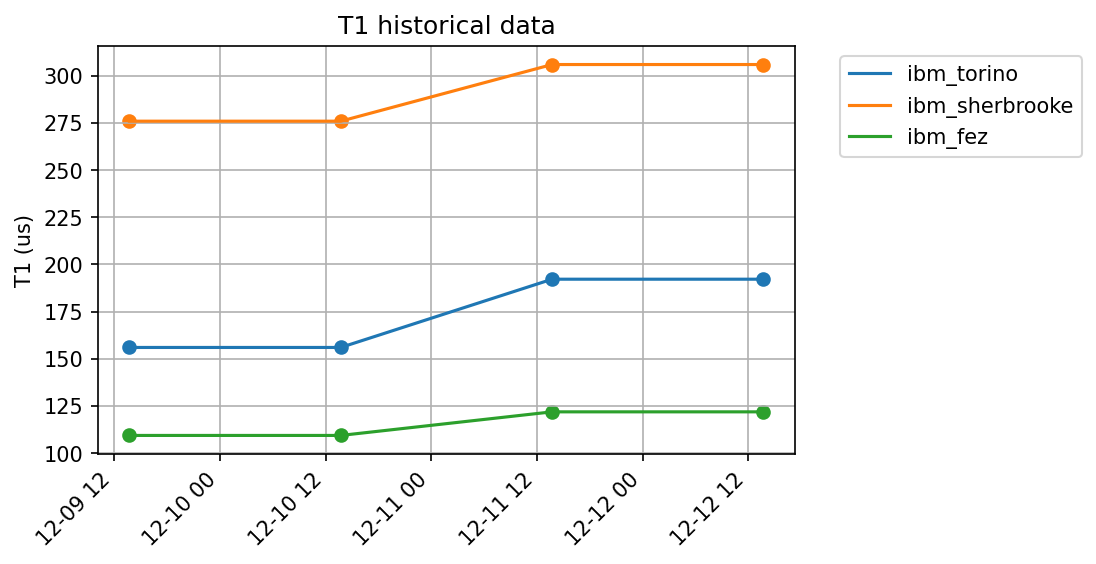

In [217]:
# plot data
plot_historical_data(dates, data_mean)

# Copyrights

In [47]:
from IPython.display import HTML, display

def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))

qiskit_copyright()